# Imports

In [35]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from keras import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import TensorBoard

import joblib
import itertools
import os
from datetime import datetime

from displayScores import display_scores
from best_dec_tree_params import bestAccuracy

# Getting familiar with the data

In [2]:
df = pd.read_csv("data/train.csv")
df[:5]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
# Check if there were any kids under the age of 1 on the board
df[df["Age"] < 1]


# Apperently there are, but I don't think this is a data issue, I think these are actual kids under 1, and not a mistake

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
78,79,1,2,"Caldwell, Master. Alden Gates",male,0.83,0,2,248738,29.0000,NaN,S
305,306,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S
469,470,1,3,"Baclini, Miss. Helene Barbara",female,0.75,2,1,2666,19.2583,NaN,C
644,645,1,3,"Baclini, Miss. Eugenie",female,0.75,2,1,2666,19.2583,NaN,C
755,756,1,2,"Hamalainen, Master. Viljo",male,0.67,1,1,250649,14.5000,NaN,S
803,804,1,3,"Thomas, Master. Assad Alexander",male,0.42,0,1,2625,8.5167,NaN,C
831,832,1,2,"Richards, Master. George Sibley",male,0.83,1,1,29106,18.7500,NaN,S


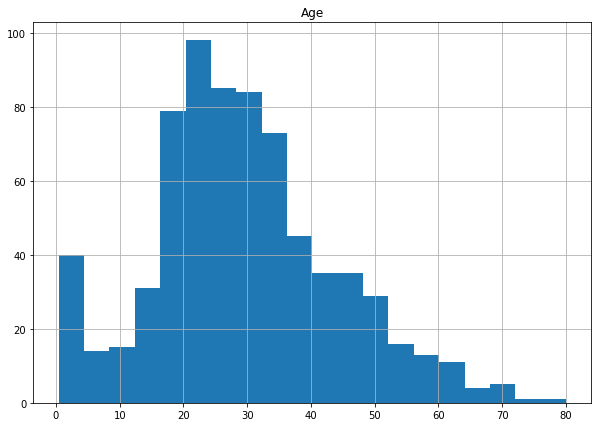

In [6]:
# Plotting the age distribution histogram
df.hist("Age", bins=20, figsize=(10,7));

In [7]:
df["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [8]:
# Let's see the correlations of the data
corr_matrix = df.corr()

In [9]:
corr_matrix["Survived"].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

In [10]:
df.max(numeric_only=True)

PassengerId    891.0000
Survived         1.0000
Pclass           3.0000
Age             80.0000
SibSp            8.0000
Parch            6.0000
Fare           512.3292
dtype: float64

In [11]:
# Check for null
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [12]:
# Check for duplicates
df.drop_duplicates()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


# Data Cleaning

In [13]:
# Creating a class that will clean df 
class CleanData():
    def transform(self,df, drop_Cabin=True): 
        clean_data = df.copy()
        if drop_Cabin:
            clean_data.drop(columns=["Cabin"], inplace=True)
        else:
            pass
        
        clean_data.drop(columns=["Name", "PassengerId"], inplace=True)
        clean_data.dropna(axis=0, subset=["Embarked"], inplace=True)  
        return clean_data


In [14]:
cd = CleanData()
clean_data = cd.transform(df)
clean_data

# I specifically didn't fill the Age column with medium to use sklearn's SimpleImputer

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,3,male,22.0,1,0,A/5 21171,7.2500,S
1,1,1,female,38.0,1,0,PC 17599,71.2833,C
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,1,1,female,35.0,1,0,113803,53.1000,S
4,0,3,male,35.0,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,211536,13.0000,S
887,1,1,female,19.0,0,0,112053,30.0000,S
888,0,3,female,NaN,1,2,W./C. 6607,23.4500,S
889,1,1,male,26.0,0,0,111369,30.0000,C


# Data Preprocessing

In [15]:
label_encoder = LabelEncoder()
sex = label_encoder.fit_transform(clean_data["Sex"])
embarked = label_encoder.fit_transform(clean_data["Embarked"])
ticket = label_encoder.fit_transform(clean_data["Ticket"])

In [16]:
encoded_data = clean_data.copy()

In [17]:
encoded_data["Sex"] = sex
encoded_data["Embarked"] = embarked
encoded_data["Ticket"] = ticket

In [18]:
encoded_data

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,3,1,22.0,1,0,522,7.2500,2
1,1,1,0,38.0,1,0,595,71.2833,0
2,1,3,0,26.0,0,0,668,7.9250,2
3,1,1,0,35.0,1,0,48,53.1000,2
4,0,3,1,35.0,0,0,471,8.0500,2
...,...,...,...,...,...,...,...,...,...
886,0,2,1,27.0,0,0,100,13.0000,2
887,1,1,0,19.0,0,0,14,30.0000,2
888,0,3,0,NaN,1,2,674,23.4500,2
889,1,1,1,26.0,0,0,8,30.0000,0


In [19]:
num_pipeline = Pipeline([
    ("imputer", SimpleImputer()),
    ("standard_scalar", Normalizer())
])

In [20]:
features = encoded_data.drop(columns=["Survived"])

In [21]:
prepared_data = num_pipeline.fit_transform(features)

In [122]:
# Splitting the data into training and testing
X = prepared_data
y = encoded_data["Survived"]
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, random_state=42)

In [56]:
prepared_data = pd.DataFrame(prepared_data, columns=features.columns, index=features.index)
prepared_data[:5]

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0.005741,0.001914,0.042103,0.001914,0.0,0.998989,0.013875,0.003828
1,0.001665,0.000000,0.063285,0.001665,0.0,0.990907,0.118714,0.000000
2,0.004487,0.000000,0.038889,0.000000,0.0,0.999159,0.011854,0.002991
3,0.012545,0.000000,0.439060,0.012545,0.0,0.602139,0.666116,0.025089
4,0.006351,0.002117,0.074093,0.000000,0.0,0.997074,0.017041,0.004234


# Training the model

In [57]:
# Let's first use the Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

In [27]:
# Evaluating the model
y_pred = log_reg.predict(X_val)
# Evaluating the model
correct = 0
y_pred = log_reg.predict(X_val)
for i in range(len(y_pred)):
    if y_pred[i] == list(y_val)[i]:
        correct += 1
    
print(f"Accuracy: {(correct/len(y_pred) * 100)}%")

Accuracy: 67.97752808988764%


In [28]:
log_reg.score(X_val, y_val)

0.6797752808988764

In [29]:
cross_val = cross_val_score(log_reg, X, y,scoring="neg_mean_squared_error" ,cv=10)

In [30]:
rmse_scores = np.sqrt(-cross_val)
rmse_scores

array([0.6271032 , 0.59962535, 0.57082633, 0.57082633, 0.56089816,
       0.55079106, 0.55079106, 0.51929079, 0.51929079, 0.51123736])

In [31]:
display_scores(rmse_scores)

Scores: [0.6271032  0.59962535 0.57082633 0.57082633 0.56089816 0.55079106
 0.55079106 0.51929079 0.51929079 0.51123736]
Mean: 0.5580680408336416
Standard deviation: 0.03483215998253276


In [32]:
# Let's try a Decision Tree Classifier
dec_tree = DecisionTreeClassifier()
dec_tree.fit(X_train, y_train)


DecisionTreeClassifier()

In [33]:
# Evaluating the model
dec_tree.score(X_val, y_val)

0.7415730337078652

In [34]:
cross_val = cross_val_score(dec_tree, X,y, scoring="neg_mean_squared_error", cv=10)

In [35]:
rmse_scores = np.sqrt(-cross_val)
rmse_scores

array([0.44971901, 0.46204236, 0.51929079, 0.50835712, 0.48575205,
       0.46204236, 0.42399915, 0.56089816, 0.43704832, 0.43952454])

In [70]:
display_scores(rmse_scores)

Scores: [0.44971901 0.46204236 0.51929079 0.50835712 0.48575205 0.46204236
 0.42399915 0.56089816 0.43704832 0.43952454]
Mean: 0.4748673871938647
Standard deviation: 0.04104040615271547


# Improving the Decistion Tree Classifier model

In [126]:
# Training with the best parameters
best_params = bestAccuracy(X_train,X_val, y_train, y_val)
model = DecisionTreeClassifier(random_state=42, criterion=best_params[0], max_depth=best_params[1], min_samples_leaf=best_params[2])

In [127]:
model.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=11, random_state=42)

In [128]:
model.score(X_val, y_val)

0.8202247191011236

In [76]:
cross_val = cross_val_score(model, X,y, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-cross_val)
rmse_scores

array([0.42399915, 0.46204236, 0.49718308, 0.39661489, 0.38218767,
       0.44971901, 0.46204236, 0.44971901, 0.44971901, 0.42640143])

In [77]:
display_scores(rmse_scores)

Scores: [0.42399915 0.46204236 0.49718308 0.39661489 0.38218767 0.44971901
 0.46204236 0.44971901 0.44971901 0.42640143]
Mean: 0.43996279895391127
Standard deviation: 0.03192253280178208


In [74]:
# Saving the model
joblib.dump(model, "models/decision_tree_best_model.pkl")

['models/decision_tree_best_model.pkl']

In [28]:
initial_df = X.copy()

In [42]:
# creating list of all available features 
all_features = list(initial_df.columns)

# Combining features into unique pairs 
lst = []
def combine2(lst, n):
    return [list(x) for x in itertools.combinations(lst, n)]

for i in range(1, len(all_features)+1):
    frst = combine2(all_features,i)
    lst = lst + frst

# Creating model with unique combination of features 
result = 0
accuracy = 0
for feature_comb  in lst :
    print(feature_comb)
    # getting data from file table 
         
    X = initial_df[feature_comb]
    
    # spliting values for model training/testing 
    X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 42, test_size= 0.2)

    # Creating and fitting the model 
    # Training with the best parameters
    best_params = bestAccuracy(X_train,X_val, y_train, y_val)
    model = DecisionTreeClassifier(random_state=42, criterion=best_params[0], max_depth=best_params[1], min_samples_leaf=best_params[2])
    model.fit(X_train , y_train)
    acc = model.score(X_val, y_val)

    if acc > accuracy:
        print(f"Accuracy: {acc}")
        accuracy = acc
        result = feature_comb
        print(result)

    

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

# Creating a model with the best found features

In [39]:
prepared_data

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0.005741,0.001914,0.042103,0.001914,0.000000,0.998989,0.013875,0.003828
1,0.001665,0.000000,0.063285,0.001665,0.000000,0.990907,0.118714,0.000000
2,0.004487,0.000000,0.038889,0.000000,0.000000,0.999159,0.011854,0.002991
3,0.012545,0.000000,0.439060,0.012545,0.000000,0.602139,0.666116,0.025089
4,0.006351,0.002117,0.074093,0.000000,0.000000,0.997074,0.017041,0.004234
...,...,...,...,...,...,...,...,...
886,0.019150,0.009575,0.258530,0.000000,0.000000,0.957519,0.124477,0.019150
887,0.026153,0.000000,0.496912,0.000000,0.000000,0.366146,0.784599,0.052307
888,0.004444,0.000000,0.043910,0.001481,0.002963,0.998412,0.034737,0.002963
889,0.024678,0.024678,0.641633,0.000000,0.000000,0.197426,0.740346,0.000000


In [131]:
best_params = initial_df[['Pclass', 'Sex', 'Parch', 'Fare']]
X_train, X_val, y_train, y_test = train_test_split(best_params, y, random_state = 42, test_size=0.2)

/var/folders/zw/c2jphy514fjdp5t_6j9278yr0000gn/T/ipykernel_74486/3611331877.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  best_params = initial_df[['Pclass', 'Sex', 'Parch', 'Fare']]


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [142]:
X_train = X_train[['Pclass', 'Sex', 'Parch', 'Fare']]
X_val = X_val[['Pclass', 'Sex', 'Parch', 'Fare']]

In [143]:
best_params = bestAccuracy(X_train,X_val, y_train, y_val)
model = DecisionTreeClassifier(random_state=42, criterion=best_params[0], max_depth=best_params[1], min_samples_leaf=best_params[2])
model.fit(X_train , y_train)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=2, random_state=42)

In [144]:
acc = model.score(X_val, y_val)
acc

0.848314606741573

In [146]:
# Saving the model
joblib.dump(model, "models/decision_tree_best_model2.pkl")

['models/decision_tree_best_model2.pkl']

# Random Forest

In [121]:
# Trying a Random Forest Classifier
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)

RandomForestClassifier()

In [122]:
random_forest.score(X_val, y_val)

0.8089887640449438

In [123]:
cross_val = cross_val_score(random_forest, X, y, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-cross_val)
rmse_scores

array([0.41053541, 0.42399915, 0.48575205, 0.39661489, 0.39661489,
       0.36719404, 0.38218767, 0.44971901, 0.39661489, 0.42640143])

In [124]:
display_scores(rmse_scores)

Scores: [0.41053541 0.42399915 0.48575205 0.39661489 0.39661489 0.36719404
 0.38218767 0.44971901 0.39661489 0.42640143]
Mean: 0.41356334408504714
Standard deviation: 0.03285974559661205


In [ ]:
joblib.dump(random_forest, "models/random_forest1.pkl")

# Random Forest with the best found features

In [129]:
best_df = X[['Pclass', 'Sex', 'Parch', 'Fare']]
X_train, X_val, y_train, y_test = train_test_split(best_df, y, random_state = 42, test_size=0.2)

In [130]:
model = RandomForestClassifier()
model.fit(X_train , y_train)

RandomForestClassifier()

In [132]:
# Evaluating the model
model.score(X_val, y_val)

0.8033707865168539

# Trying Grid Search CV

In [133]:
param_grid =[
    {"n_estimators": [3, 10, 30, 35, 40], "max_features": [2,3, 4, 5, 6, 7, 8]},
    {"bootstrap": [False], "n_estimators": [3, 10, 30, 35, 49], "max_features": [2,3, 4, 5, 6, 7, 8]},
]

In [139]:
grid_search = GridSearchCV(model, param_grid, cv=5, scoring="accuracy", return_train_score=True)

In [140]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'max_features': [2, 3, 4, 5, 6, 7, 8],
                          'n_estimators': [3, 10, 30, 35, 40]},
                         {'bootstrap': [False],
                          'max_features': [2, 3, 4, 5, 6, 7, 8],
                          'n_estimators': [3, 10, 30, 35, 49]}],
             return_train_score=True, scoring='accuracy')

In [141]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [142]:
grid_search.score(X_val, y_val)

0.7865168539325843

In [282]:
attrs = list(X.columns)
attrs

['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked']

In [283]:
f_importance = grid_search.best_estimator_.feature_importances_

In [285]:
sorted(zip(f_importance, attrs), reverse=True)

[(0.31456909241400005, 'Sex'),
 (0.1634520799666993, 'Fare'),
 (0.13376177118626992, 'Ticket'),
 (0.1156877978664645, 'Age'),
 (0.08989928097473696, 'Pclass'),
 (0.08655518423758615, 'Embarked'),
 (0.06358471185695798, 'SibSp'),
 (0.03249008149728523, 'Parch')]

In [288]:
cross_val = cross_val_score(grid_search, X, y, scoring="neg_mean_squared_error",cv=10)

In [289]:
rmse_scores = np.sqrt(-cross_val)

In [292]:
display_scores(rmse_scores)

Scores: [0.42399915 0.39661489 0.50835712 0.41053541 0.35156152 0.41053541
 0.43704832 0.43704832 0.38218767 0.41286141]
Mean: 0.4170749245627191
Standard deviation: 0.038999078689009106


# Making predictions on the test data

In [149]:
test_data = pd.read_csv("data/test.csv")
test_data = test_data[X_train.columns]
test_data = test_data[['Pclass', 'Sex', 'Parch', 'Fare']]
test_data.head()

,Pclass,Sex,Parch,Fare
0,3,male,0,7.8292
1,3,female,0,7.0000
2,2,male,0,9.6875
3,3,male,0,8.6625
4,3,female,1,12.2875


In [154]:
label_encoder = LabelEncoder()
sex = label_encoder.fit_transform(test_data["Sex"])
test_data["Sex"] = sex
test_data

,Pclass,Sex,Parch,Fare
0,3,1,0,7.8292
1,3,0,0,7.0000
2,2,1,0,9.6875
3,3,1,0,8.6625
4,3,0,1,12.2875
...,...,...,...,...
413,3,1,0,8.0500
414,1,0,0,108.9000
415,3,1,0,7.2500
416,3,1,0,8.0500


In [155]:
num_pipeline = Pipeline([
    ("imputer", SimpleImputer()),
    ("standard_scalar", Normalizer())
])

test_data = num_pipeline.fit_transform(test_data)

In [161]:
best_model = joblib.load("models/decision_tree_best_model2.pkl")
final_predictions = best_model.predict(test_data)

/Users/andriievskyi/tensorflow-env/env/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [174]:
submission_data = pd.read_csv("data/test.csv")
submission_data = submission_data[["PassengerId"]]
submission_data["Survived"] = final_predictions
submission_data.to_csv("final_submission.csv", index=False )

In [175]:
pd.read_csv("final_submission.csv")

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
